## This notebook is part of Hadoop and Spark training delivered by IT-DB group
### SPARK RDD Hands-On Lab
_ by Prasanth Kothuri _

### Hands-On 1 - Load and inspect the data from HDFS

#### Please execute the following steps if you are running in Spark local mode
*SPARK context must be explicity created in local mode*

In [1]:
from pyspark import SparkContext

In [2]:
sc = SparkContext()

#### Run the following cell to create an rdd containing the UN Pop Stats data

In [3]:
rdd = sc.textFile("../data/UN_Pop_Stats.csv")

#### Lets see if the rdd contains any data; take(n) - returns the first n elements of the RDD

In [4]:
rdd.take(5)

[u'LocID,Location,VarID,Variant,Time,MidPeriod,SexID,Sex,AgeGrp,AgeGrpStart,AgeGrpSpan,Value',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","0-4",0,5,630.044',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","5-9",5,5,516.205',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","10-14",10,5,461.378',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","15-19",15,5,414.368']

#### oops, there is a header, lets remove it first

In [5]:
headless_rdd = rdd.filter(lambda line: 'LocID' not in line)

#### inspect the data to see if the header is still present

In [6]:
headless_rdd.take(5)

[u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","0-4",0,5,630.044',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","5-9",5,5,516.205',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","10-14",10,5,461.378',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","15-19",15,5,414.368',
 u'4,"Afghanistan",2,"Medium","1950",1950.5,1,"Male","20-24",20,5,374.110']

### Hands-On 2 - Convert headless_rdd to an RDD containing python namedtuple objects

#### Lets import couple of things we need

In [7]:
from collections import namedtuple
from pprint import pprint

#### schema for the namedtuple
*Named tuples are tuples that allow their elements to be accessed by name instead of just index*

In [8]:
pData = namedtuple('pData',['LocID','Location','VarID','Variant','Time','MidPeriod','SexID','Sex','AgeGrp','AgeGrpStart','AgeGrpSpan','Value'])

#### Function to map the data

In [9]:
def map_record(record):
  columns = record.split(",")[:12]
  return pData(*columns)

#### The following map created new python namedtuple rdd

In [10]:
ntuple_rdd = headless_rdd.map(map_record)

#### Inspect the data

In [11]:
ntuple_rdd.take(5)

[pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Male"', AgeGrp=u'"0-4"', AgeGrpStart=u'0', AgeGrpSpan=u'5', Value=u'630.044'),
 pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Male"', AgeGrp=u'"5-9"', AgeGrpStart=u'5', AgeGrpSpan=u'5', Value=u'516.205'),
 pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Male"', AgeGrp=u'"10-14"', AgeGrpStart=u'10', AgeGrpSpan=u'5', Value=u'461.378'),
 pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Male"', AgeGrp=u'"15-19"', AgeGrpStart=u'15', AgeGrpSpan=u'5', Value=u'414.368'),
 pData(LocID=u'4', Location=u'"Afghanistan"', VarID=u'2', Variant=u'"Medium"', Time=u'"1950"', MidPeriod=u'1950.5', SexID=u'1', Sex=u'"Mal

### Hands-On 3 - Aggregate the population by Age Group for Switzerland for 2015
*This introduces filter, map, reduceByKey transformations and collect actions*

In [12]:
plot_rdd = ntuple_rdd.filter(lambda record: record.Location =='"Switzerland"' and record.Time == '"2015"' and record.Sex in ['"Male"','"Female"']) \
    .map(lambda record: (int(record.AgeGrpStart),int(float(record.Value)*1000))) \
    .reduceByKey(lambda x,y: x+y) \
    .sortByKey() \
    .collect()

#### Lets draw the population distribution histogram

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt

/cvmfs/sft.cern.ch/lcg/releases/matplotlib/1.5.1-763af/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<IPython.core.display.Javascript object>


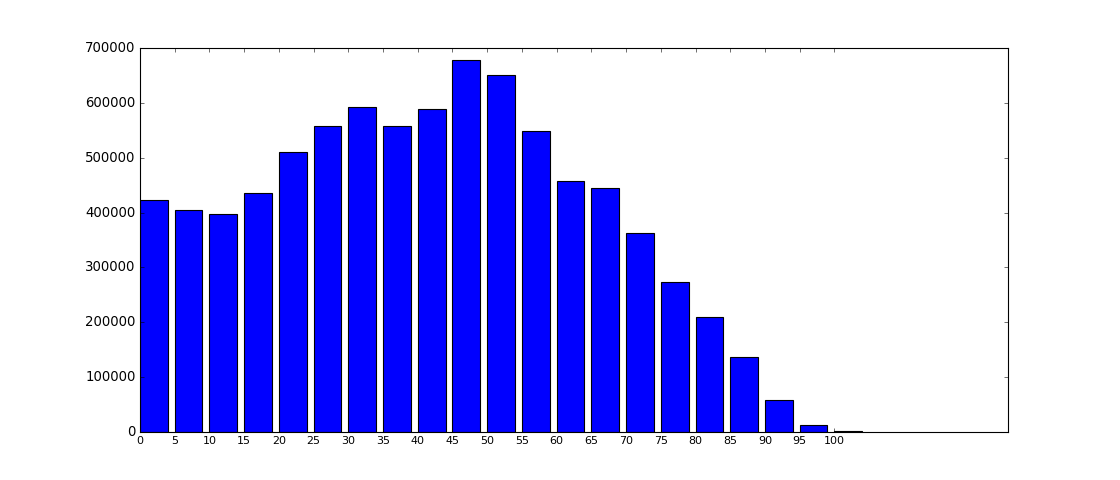

[(0, 423175), (5, 405366), (10, 397616), (15, 435016), (20, 509516), (25, 557227), (30, 591613), (35, 557624), (40, 589307), (45, 677384), (50, 651470), (55, 548059), (60, 458058), (65, 445100), (70, 362208), (75, 273224), (80, 209059), (85, 136121), (90, 57859), (95, 12047), (100, 1614)]


In [14]:
plt.figure(figsize=(14,6))
x_val = [x[0] for x in sorted(plot_rdd)]
y_val = [x[1] for x in sorted(plot_rdd)]
print plot_rdd
plt.bar(range(len(y_val)), y_val)
plt.xticks(range(len(x_val)), x_val, size='small')
plt.show()

### Exercise 1 - show the centenarian populations by country for 2015 ordered by values in the decending order 
*Hint - this requires use of filter, map, reduceByKey and sortByKey*

In [15]:
# %load key/solution1.py
ntuple_rdd.filter(lambda record: record.AgeGrp =='"100+"' and record.Time == '"2015"' and record.Sex == '"Both"') \
    .map(lambda record: (record.Location,int(float(record.Value)*1000))) \
    .reduceByKey(lambda x,y: x+y) \
    .map(lambda (x,y):(y,x)).sortByKey(False) \
    .collect() \


[(450895, u'"WORLD"'),
 (265497, u'"More developed regions"'),
 (188964, u'"ASIA"'),
 (185398, u'"Less developed regions"'),
 (120820, u'"EUROPE"'),
 (116299, u'"Eastern Asia"'),
 (79724, u'"NORTHERN AMERICA"'),
 (71972, u'"United States of America"'),
 (60630, u'"Japan"'),
 (52418, u'"LATIN AMERICA AND THE CARIBBEAN"'),
 (47657, u'"China"'),
 (43016, u'"Western Europe"'),
 (40113, u'"Southern Europe"'),
 (37957, u'"South-Central Asia"'),
 (35490, u'"Southern Asia"'),
 (30926, u'"South-Eastern Asia"'),
 (29501, u'"South America"'),
 (27266, u'"India"'),
 (24592, u'"Italy"'),
 (23838, u'"Viet Nam"'),
 (21103, u'"Northern Europe"'),
 (19768, u'"France"'),
 (16588, u'"Eastern Europe"'),
 (16227, u'"United Kingdom"'),
 (16096, u'"Germany"'),
 (13556, u'"Central America"'),
 (11090, u'"Mexico"'),
 (9860, u'"Spain"'),
 (9361, u'"Caribbean"'),
 (7739, u'"Canada"'),
 (7629, u'"Least developed countries"'),
 (6077, u'"Brazil"'),
 (5956, u'"Argentina"'),
 (5733, u'"Bangladesh"'),
 (5586, u'"Chil

### Hands-On 4 - Calculate the male to female ratio across Locations (countries) and Time (years)
*This introduces transformations join rdd, combineByKey, groupByKey and reduceByKey*

#### First, lets import couple of bits we need

In [15]:
from operator import add

#### calculate the total male population for each Location (country) and Time (year)

In [16]:
m_rdd = ntuple_rdd.filter(lambda record: record.Sex == '"Male"') \
    .map(lambda record: ((record.Location,record.Time,record.Sex),float(record.Value))) \
    .reduceByKey(add) \
    .map(lambda record: ((record[0][0],record[0][1]),(record[0][2],record[1])))

#### inspect the rdd

In [17]:
m_rdd.take(5)

[((u'"Slovenia"', u'"2050"'), (u'"Male"', 966.206)),
 ((u'"Cyprus"', u'"1980"'), (u'"Male"', 345.128)),
 ((u'"Denmark"', u'"1990"'), (u'"Male"', 2534.6839999999993)),
 ((u'"Djibouti"', u'"2040"'), (u'"Male"', 565.81)),
 ((u'"South America"', u'"1975"'), (u'"Male"', 108229.85500000001))]

#### calculate the total female population for each Location (country) and Time (year)

In [18]:
f_rdd = ntuple_rdd.filter(lambda record: record.Sex == '"Female"') \
    .map(lambda record: ((record.Location,record.Time,record.Sex),float(record.Value))) \
    .reduceByKey(add) \
    .map(lambda record: ((record[0][0],record[0][1]),(record[0][2],record[1])))

#### inspect how the data looks in the rdd

In [20]:
f_rdd.take(5)

[((u'"OCEANIA"', u'"2075"'), (u'"Female"', 32741.462000000003)),
 ((u'"Northern Africa"', u'"2000"'), (u'"Female"', 85484.0)),
 ((u'"Botswana"', u'"2095"'), (u'"Female"', 1868.8210000000004)),
 ((u'"New Caledonia"', u'"1960"'), (u'"Female"', 36.908)),
 ((u'"Bulgaria"', u'"2060"'), (u'"Female"', 2378.8529999999996))]

#### join the rdd's

In [21]:
join_rdd = m_rdd.join(f_rdd)

#### inspect the data in the join_rdd

In [22]:
join_rdd.take(5)

[((u'"Aruba"', u'"1955"'),
  ((u'"Male"', 21.275), (u'"Female"', 22.451999999999998))),
 ((u'"Western Africa"', u'"2020"'),
  ((u'"Male"', 203617.22200000004), (u'"Female"', 199213.89299999998))),
 ((u'"Fiji"', u'"1980"'),
  ((u'"Male"', 321.61099999999993), (u'"Female"', 313.645))),
 ((u'"Brunei Darussalam"', u'"2045"'),
  ((u'"Male"', 275.21299999999997), (u'"Female"', 263.73199999999997))),
 ((u'"Romania"', u'"1980"'),
  ((u'"Male"', 11152.395), (u'"Female"', 11459.754)))]

#### final rdd containing the male to female ratio for each country and year

In [23]:
fn_rdd = join_rdd.map(lambda record: (record[1][0][1]/record[1][1][1],(record[0][0],record[0][1])))

#### since the output is going to be huge, lets just filer for Estonia

In [24]:
ratio_rdd = fn_rdd.filter(lambda record: record[1][0] == '"Estonia"').map(lambda (x,y): (y,x)).sortByKey().collect()

<IPython.core.display.Javascript object>


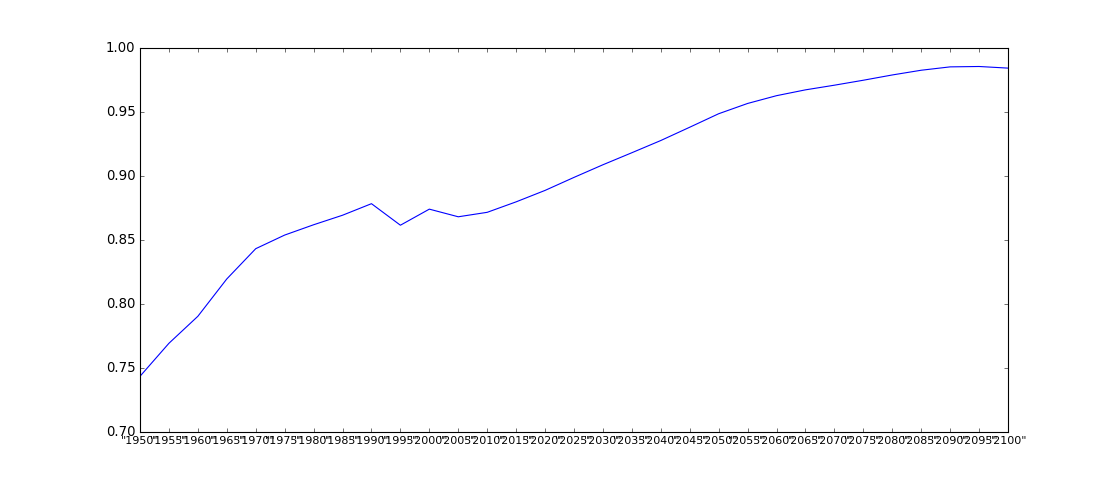

[(0, 423175), (5, 405366), (10, 397616), (15, 435016), (20, 509516), (25, 557227), (30, 591613), (35, 557624), (40, 589307), (45, 677384), (50, 651470), (55, 548059), (60, 458058), (65, 445100), (70, 362208), (75, 273224), (80, 209059), (85, 136121), (90, 57859), (95, 12047), (100, 1614)]


In [25]:
plt.figure(figsize=(14,6))
x_val = [x[0][1] for x in sorted(ratio_rdd)]
y_val = [x[1] for x in sorted(ratio_rdd)]
print plot_rdd
plt.plot(range(len(y_val)), y_val)
plt.xticks(range(len(x_val)), x_val, size='small')
plt.show()

#### And finally countries with extreme ratios!

In [26]:
fn_rdd.filter(lambda record: record[0] > 2.5 or record[0] < 0.8).sortByKey().collect()

[(0.7435255068268413, (u'"Estonia"', u'"1950"')),
 (0.7519791094575811, (u'"Ukraine"', u'"1950"')),
 (0.7616614030742755, (u'"Latvia"', u'"1950"')),
 (0.7656062654146911, (u'"Russian Federation"', u'"1950"')),
 (0.7693076696484855, (u'"Estonia"', u'"1955"')),
 (0.7786593567288499, (u'"Ukraine"', u'"1955"')),
 (0.7818550487288757, (u'"Latvia"', u'"1955"')),
 (0.7904025801857155, (u'"Estonia"', u'"1960"')),
 (0.790463501357167, (u'"Russian Federation"', u'"1955"')),
 (0.7920474390414033, (u'"Latvia"', u'"1960"')),
 (0.7924057107018961, (u'"Belarus"', u'"1950"')),
 (0.7926861628890858, (u'"Martinique"', u'"2050"')),
 (0.7951457618687366, (u'"Martinique"', u'"2055"')),
 (0.7963798926115795, (u'"Martinique"', u'"2045"')),
 (2.5201461958857134, (u'"United Arab Emirates"', u'"2020"')),
 (2.6547145687958205, (u'"Qatar"', u'"2015"')),
 (2.739509463565873, (u'"United Arab Emirates"', u'"2015"')),
 (2.9712132495620898, (u'"United Arab Emirates"', u'"2010"')),
 (3.056841316746095, (u'"Qatar"', u'"

#### Exercise 2 - how to achieve the same with groupByKey

In [ ]:
%load key/solution2.py

#### Exercise 3 - how to achieve the same with reduceByKey 

In [ ]:
%load key/solution3.py

#### Exercise 4 - how to achieve the same with combineByKey 

In [ ]:
%load key/solution4.py

### HandsOn 5 - Calculate the old-age dependency ratio (ratio of pop between 65+ to 25-64)
*This introduces brodcast variables*

#### create broadcast variable, good for performance for map-side join (for lookup table or feature vector)

In [27]:
broadcastWorkingAge = sc.broadcast([25,30,35,40,45,50,55,60])

#### Function to map the record as WORKING or RETIRED based on age

In [28]:
def map_agegrp(record):
    if int(record.AgeGrpStart) in broadcastWorkingAge.value:
         AgeGroup = 'WORKING'
    else:
         AgeGroup = 'RETIRED'
    return ((record.Location,record.Time,AgeGroup),float(record.Value))

#### Function to calculate the ratio

In [29]:
def cal_ratio(record):
    if record[1][0] == 'WORKING':
         ratio = record[1][3] / record[1][1]
    else:
         ratio = record[1][1] / record[1][3]
    return (ratio,(record[0][0],record[0][1]))

#### rdd holding the old-age dependency ratio for each country and for each year

In [30]:
ntuple_rdd.filter(lambda record: record.Sex == '"Both"' and int(record.AgeGrpStart) not in [0,5,10,15,20]) \
    .map(map_agegrp) \
    .reduceByKey(add) \
    .map(lambda record: ((record[0][0],record[0][1]),(record[0][2],record[1]))) \
    .reduceByKey(lambda a, b: a + b) \
    .map(cal_ratio) \
    .take(10)

[(0.05178322122096713, (u'"Aruba"', u'"1955"')),
 (0.3030251557114507, (u'"Kazakhstan"', u'"2060"')),
 (0.07844674506650585, (u'"Nepal"', u'"1970"')),
 (0.14458087541014408, (u'"Nepal"', u'"2030"')),
 (0.08148086607991036, (u'"Western Africa"', u'"2020"')),
 (0.1511617660018212, (u'"Tonga"', u'"1995"')),
 (0.07089940611032879, (u'"Fiji"', u'"1980"')),
 (0.0912807078099758, (u'"Iran (Islamic Republic of)"', u'"2015"')),
 (0.09640098842572788, (u'"Mozambique"', u'"2000"')),
 (0.23670364293021603, (u'"Togo"', u'"2090"'))]

### HandsOn 6 - some misc. rdd functions

#### check the number of partitions in RDD

In [27]:
ntuple_rdd.getNumPartitions()

2

#### repartition the RDD

In [28]:
rep_rdd = ntuple_rdd.repartition(5)

#### check again the number of partitions

In [29]:
rep_rdd.getNumPartitions()

5

#### which rdd to cache?

In [30]:
ntuple_rdd.cache()

PythonRDD[54] at RDD at PythonRDD.scala:48

#### each rdd has an id and can be given a friendly name

In [31]:
rdd.id()

1

In [32]:
rdd.name()

u'../data/UN_Pop_Stats.csv'

#### get distinct values of a column

In [33]:
ntuple_rdd.map(lambda record: record.Location).distinct().collect()

[u'"Bahrain"',
 u'"Dominican Republic"',
 u'"Fiji"',
 u'"Caribbean"',
 u'"Armenia"',
 u'"Aruba"',
 u'"Uganda"',
 u'"Western Europe"',
 u'"Paraguay"',
 u'"Micronesia (Fed. States of)"',
 u'"Ghana"',
 u'"Lithuania"',
 u'"Canada"',
 u'"Venezuela (Bolivarian Republic of)"',
 u'"Spain"',
 u'"Swaziland"',
 u'"Samoa"',
 u'"Ecuador"',
 u'"Bahamas"',
 u'"Romania"',
 u'"Republic of Korea"',
 u'"India"',
 u'"Tajikistan"',
 u'"Sudan"',
 u'"Slovakia"',
 u'"United States Virgin Islands"',
 u'"Iran (Islamic Republic of)"',
 u'"NORTHERN AMERICA"',
 u'"Malta"',
 u'"Mongolia"',
 u'"Belgium"',
 u'"Western Sahara"',
 u'"United Kingdom"',
 u'"Nicaragua"',
 u'"Turkey"',
 u'"Barbados"',
 u'"Egypt"',
 u'"Angola"',
 u'"Jordan"',
 u'"Djibouti"',
 u'"Italy"',
 u'"Saudi Arabia"',
 u'"AFRICA"',
 u'"Mozambique"',
 u'"Croatia"',
 u'"Sao Tome and Principe"',
 u'"Gabon"',
 u'"Middle Africa"',
 u'"Tonga"',
 u'"French Guiana"',
 u'"Poland"',
 u'"Austria"',
 u'"Bhutan"',
 u'"Burundi"',
 u'"Libya"',
 u'"Tunisia"',
 u'"Zam

### Hands-On 7 - Convert the ntuple_rdd to DataFrame and save the DF as parquet file

#### Create sqlContext
*This is only required if you are running in SPARK local mode*

In [34]:
from pyspark import SQLContext

In [35]:
sqlContext = SQLContext(sc)

#### Convert RDD to DF and inspect the data

In [36]:
df = ntuple_rdd.toDF()

In [37]:
df.show()

+-----+-------------+-----+--------+------+---------+-----+--------+-------+-----------+----------+-------+
|LocID|     Location|VarID| Variant|  Time|MidPeriod|SexID|     Sex| AgeGrp|AgeGrpStart|AgeGrpSpan|  Value|
+-----+-------------+-----+--------+------+---------+-----+--------+-------+-----------+----------+-------+
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|  "0-4"|          0|         5|630.044|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|  "5-9"|          5|         5|516.205|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|"10-14"|         10|         5|461.378|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|"15-19"|         15|         5|414.368|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|"20-24"|         20|         5|374.110|
|    4|"Afghanistan"|    2|"Medium"|"1950"|   1950.5|    1|  "Male"|"25-29"|         25|         5|321.312|
|    4|"Afghanistan"|    2|"